In [37]:
# 跑完這個 就可以call db了
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
CURRENT_DIR = Path(os.getcwd())
PROJECT_ROOT = CURRENT_DIR.parent  # 如果你在 notebook/ 裡執行
sys.path.insert(0, str(PROJECT_ROOT))
from src.config import SQLALCHEMY_DATABASE_URI
from sqlalchemy import create_engine
engine = create_engine(SQLALCHEMY_DATABASE_URI)

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import gpxpy

In [52]:
df = pd.read_sql('hiking', con=engine)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   end_date                   540 non-null    datetime64[ns]
 1   file_name_x                540 non-null    object        
 2   user                       540 non-null    object        
 3   distance                   540 non-null    float64       
 4   total_ascent               540 non-null    float64       
 5   total_descent              540 non-null    float64       
 6   total_time                 540 non-null    int64         
 7   time_to_max_elevation_min  540 non-null    int64         
 8   time_from_max_to_end_min   540 non-null    int64         
 9   max_elevation_time         540 non-null    object        
 10  station_id                 540 non-null    object        
 11  season                     540 non-null    object        
 12  temperat

In [53]:
df_1 = df[['distance', 'total_time']]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_1)
df_scaled

array([[-1.60430568, -1.89854425],
       [-1.60430568, -1.89854425],
       [ 0.06771494,  0.14875305],
       ...,
       [-0.04147824, -0.99682605],
       [ 0.09046352, -0.07242312],
       [ 0.09046352, -0.07242312]], shape=(540, 2))

In [55]:
db = DBSCAN(eps=0.5, min_samples=3).fit(df_scaled)
labels = db.labels_
df['cluster'] = db.labels_

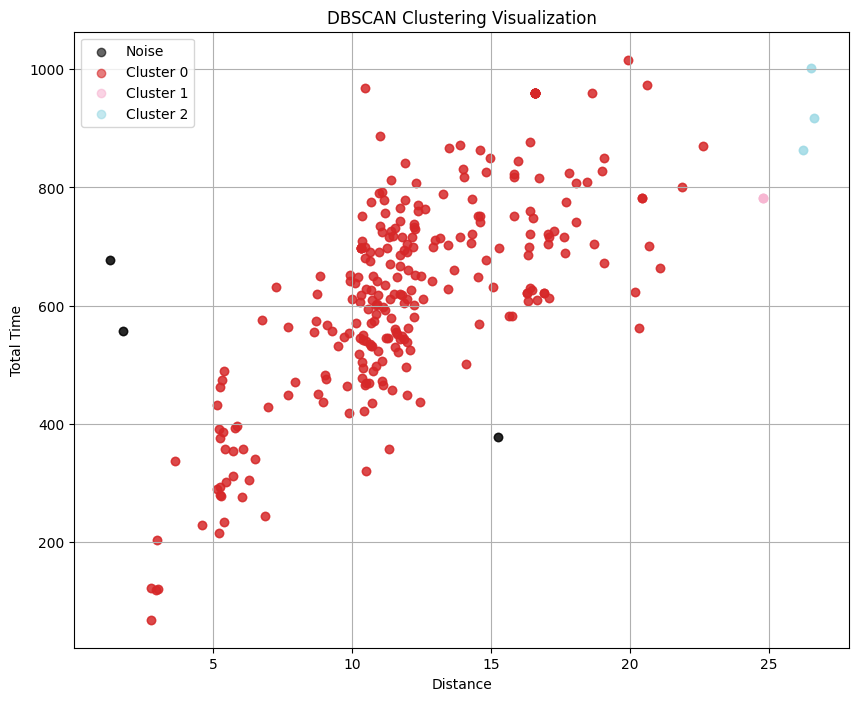

In [50]:
unique_labels = np.unique(labels)
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))  # 給每群不同顏色

plt.figure(figsize=(10, 8))
for k, col in zip(unique_labels, colors):
    class_mask = (labels == k)
    if k == -1:
        # 噪音用黑色
        col = 'k'
    plt.scatter(df.loc[class_mask, 'distance'],
                df.loc[class_mask, 'total_time'],
                c=[col], label=f'Cluster {k}' if k != -1 else 'Noise', alpha=0.6)

plt.xlabel('Distance')
plt.ylabel('Total Time')
plt.title('DBSCAN Clustering Visualization')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
target = df[df['cluster'] != 0]['file_name_x'].to_list()

處理中：1120504 一日武陵四秀(桃山、喀拉業山、池有山、品田山).gpx


C:\Users\student\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32239 (\N{CJK UNIFIED IDEOGRAPH-7DEF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34892 (\N{CJK UNIFIED IDEOGRAPH-884C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24465 (\N{CJK UNIFIED IDEOGRAPH-5F91}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\student\AppData\Roaming\Python\Python313\site-packages\IPython\core\pyl

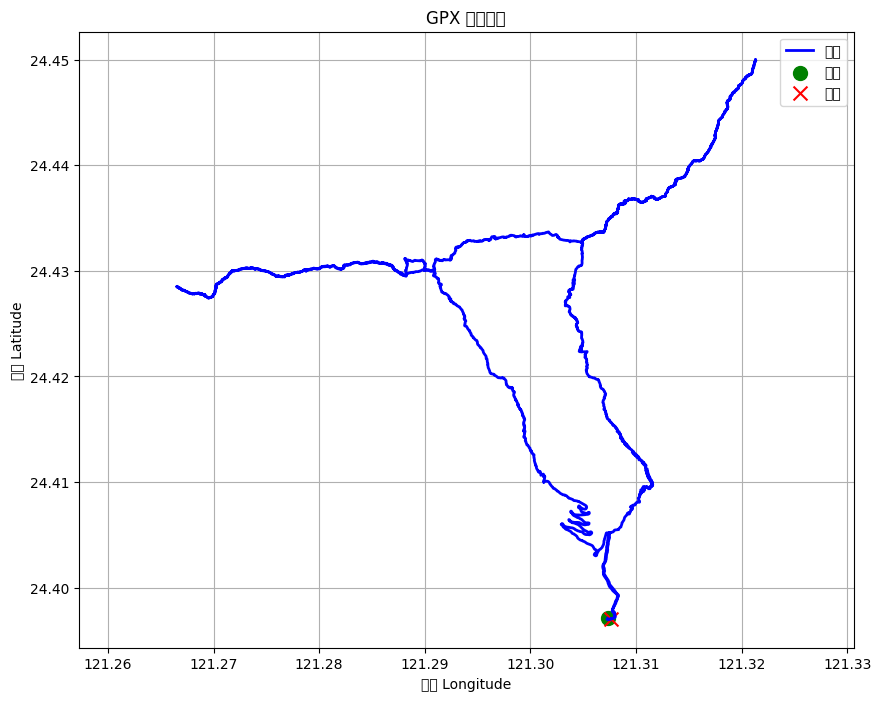

處理中：20181229_一日三秀-品田 池有 桃山.gpx


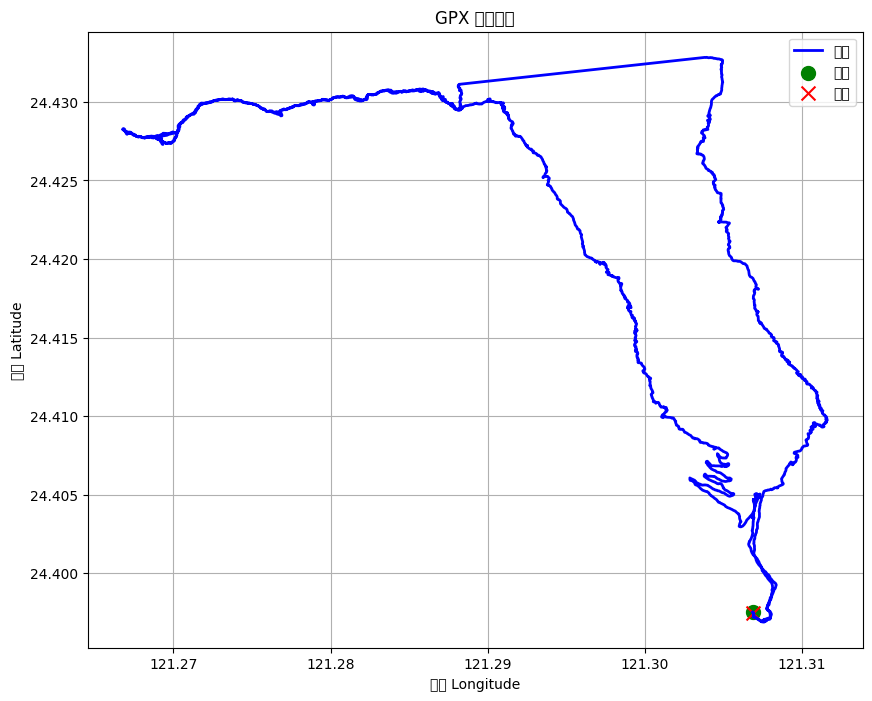

處理中：一日武陵四秀 (1).gpx


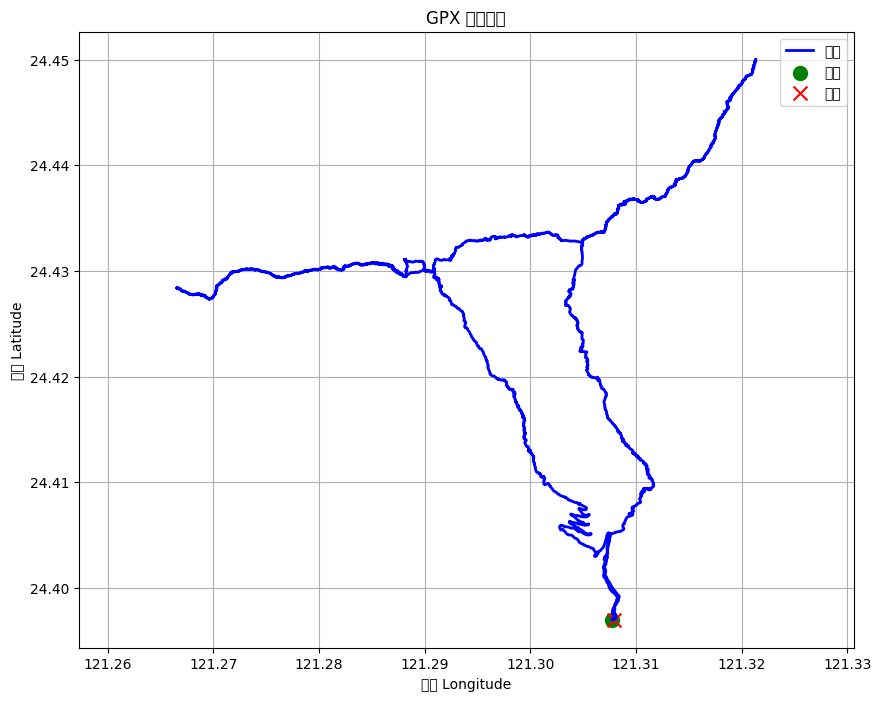

處理中：台中－臺灣百大必訪步道武陵四秀登山步道20241222173230.gpx


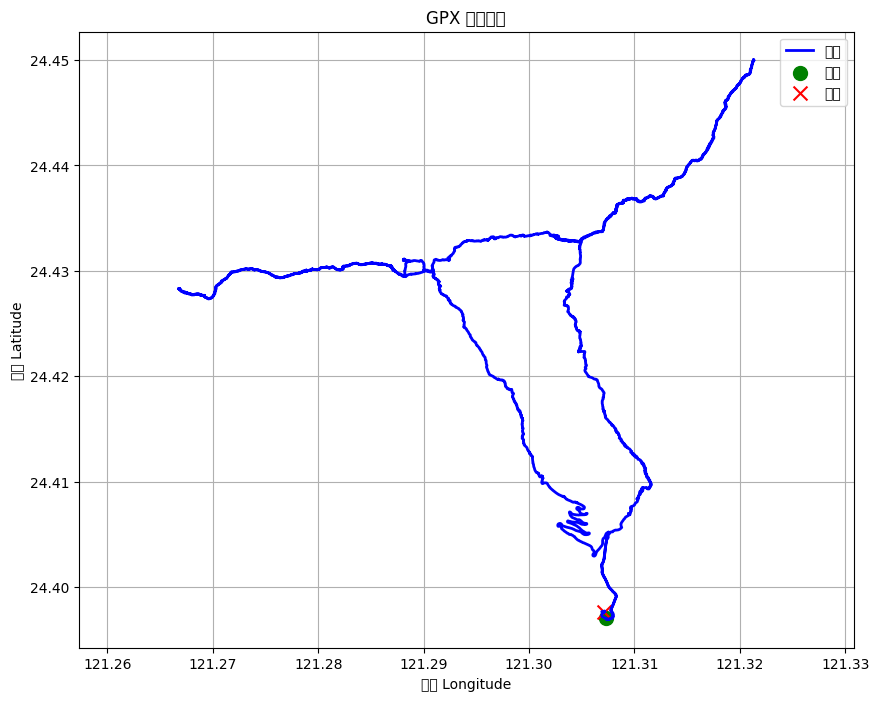

處理中：品田山-池有山-桃山一日單攻.gpx


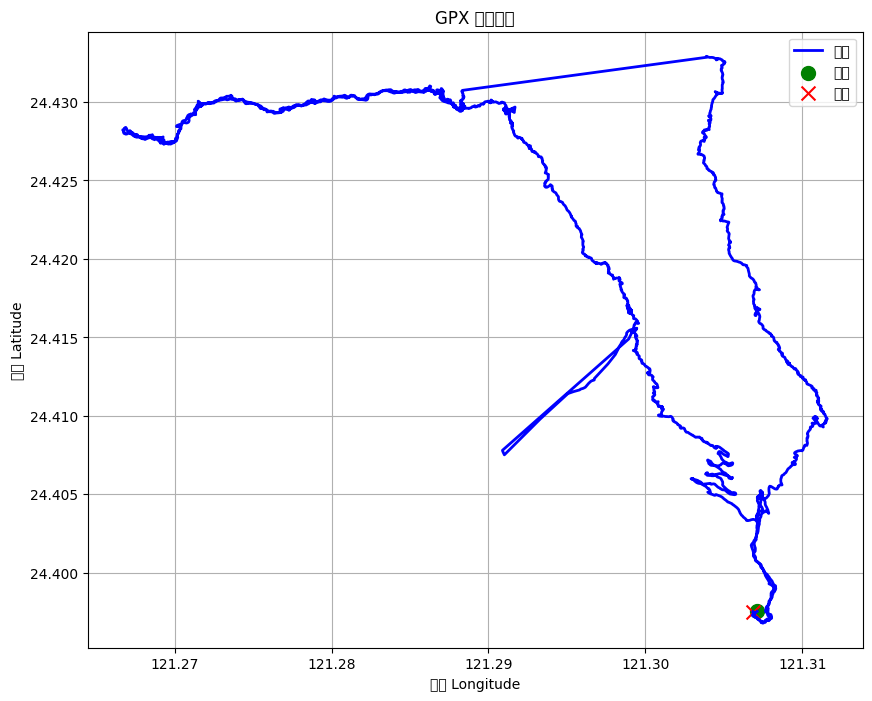

處理中：桃山三角點-桃山山屋.gpx


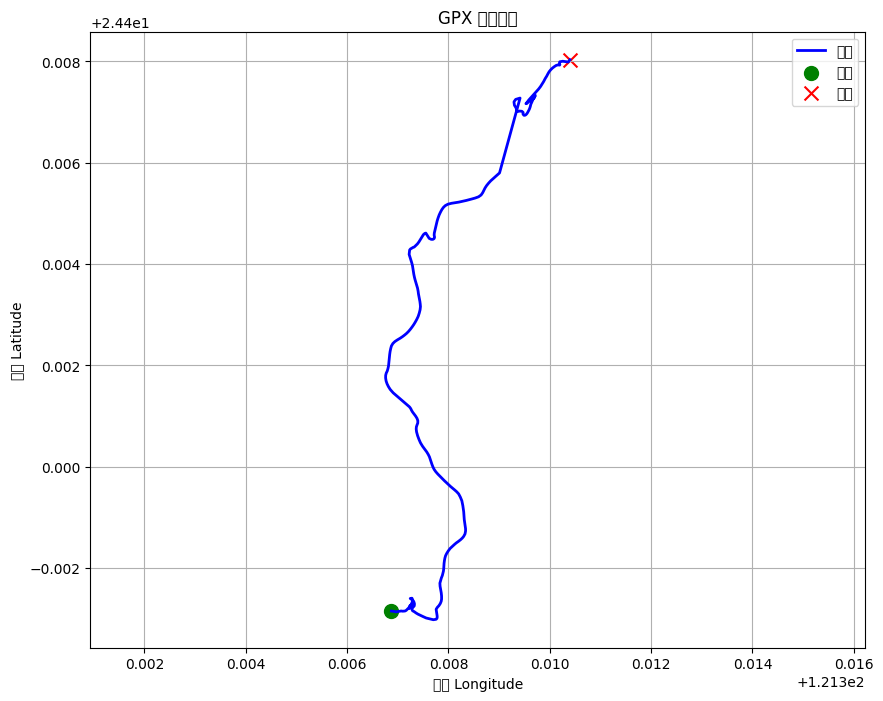

處理中：桃山單攻 (4).gpx


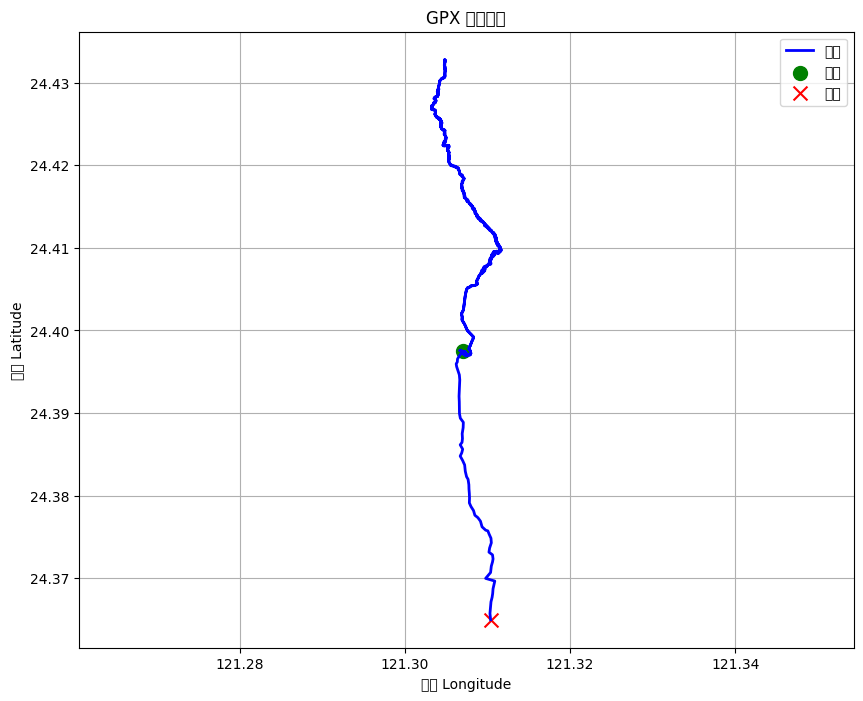

處理中：武陵桃山.gpx


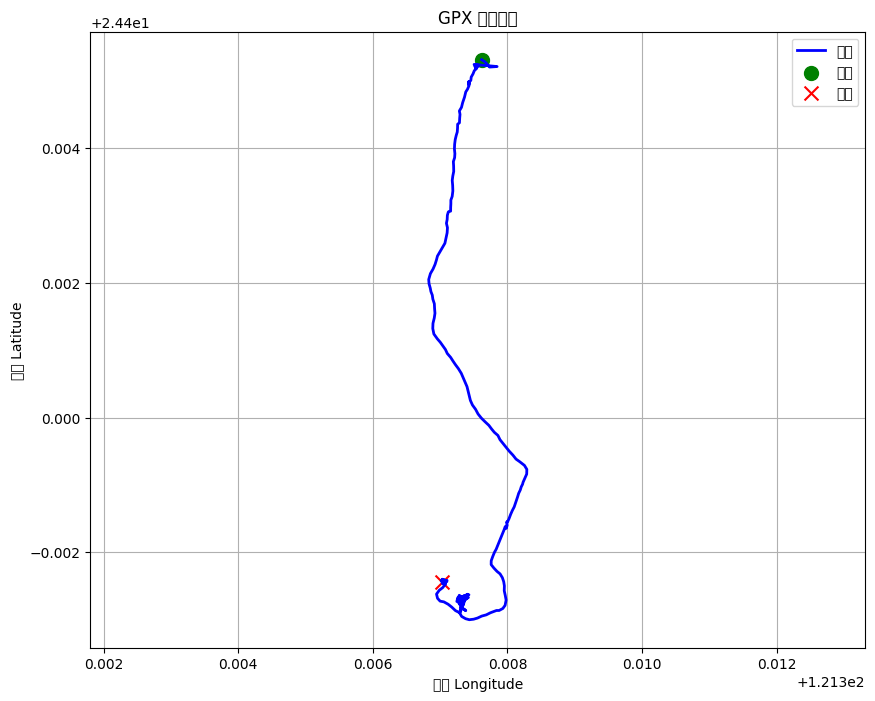

In [57]:
path = r'../data/raw/gpx'

for fname in os.listdir(path):
    if fname in target and fname.endswith('.gpx'):
        fpath = os.path.join(path, fname)
        print(f"處理中：{fname}")
        with open(fpath, 'r', encoding='utf-8') as f:
            gpx = gpxpy.parse(f)
        lats, lons = [], []
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    lats.append(point.latitude)
                    lons.append(point.longitude)

        if not lats:
            raise ValueError("GPX檔沒有讀到任何軌跡點")

        # 畫圖
        plt.figure(figsize=(10, 8))
        plt.plot(lons, lats, color='blue', linewidth=2, label='路線')
        plt.scatter(lons[0], lats[0], color='green', marker='o', s=100, label='起點')
        plt.scatter(lons[-1], lats[-1], color='red', marker='x', s=100, label='終點')

        plt.title("GPX 行徑路線")
        plt.xlabel("經度 Longitude")
        plt.ylabel("緯度 Latitude")
        plt.legend()
        plt.grid(True)
        plt.axis('equal')  # 維持比例
        plt.show()
